# You Have to run DataDownload.ipynb First!

In [1]:
!pip install monai
!pip install natsort

In [2]:
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm
from IPython.display import display
from scipy import ndimage
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

In [3]:
class cfg: 
    base_path = Path('/root/Data/BraTS2020_training_data/content/data')

Total 57198 data in this directory

### 1.1 Check & Counting data
* chckout basic data count

In [4]:
extensions = set()

# 디렉토리 내 모든 파일의 확장자 집계
for file in cfg.base_path.rglob('*'):
    if file.is_file():
        extensions.add(file.suffix)
    
print(extensions)

{'.csv', '.h5'}


* result: there are tow file type h5 for data and csv file for metadata

In [5]:
# .csv 파일 목록 생성
h5_files = [file for file in cfg.base_path.rglob('*.h5') if file.is_file()]
csv_files = [file for file in cfg.base_path.rglob('*.csv') if file.is_file()]

In [6]:
print(csv_files)

[PosixPath('/root/Data/BraTS2020_training_data/content/data/name_mapping.csv'), PosixPath('/root/Data/BraTS2020_training_data/content/data/survival_info.csv'), PosixPath('/root/Data/BraTS2020_training_data/content/data/meta_data.csv')]


In [7]:
dataframes = {}
for file in csv_files:
    df = pd.read_csv(str(file))
    dataframes[file.name] = df

print(dataframes.keys())

dict_keys(['name_mapping.csv', 'survival_info.csv', 'meta_data.csv'])


In [8]:
dataframes["name_mapping.csv"].head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [9]:
dataframes["survival_info.csv"].head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [10]:
dataframes["meta_data.csv"].head()

,slice_path,target,volume,slice
0,/content/data/volume_41_slice_0.h5,0,41,0
1,/content/data/volume_41_slice_1.h5,0,41,1
2,/content/data/volume_41_slice_2.h5,0,41,2
3,/content/data/volume_41_slice_3.h5,0,41,3
4,/content/data/volume_41_slice_4.h5,0,41,4


In [11]:
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = h5_files[25070]
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")

Found 57195 .h5 files:
Example file names:[PosixPath('/root/Data/BraTS2020_training_data/content/data/volume_89_slice_58.h5'), PosixPath('/root/Data/BraTS2020_training_data/content/data/volume_184_slice_140.h5'), PosixPath('/root/Data/BraTS2020_training_data/content/data/volume_177_slice_0.h5')]

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 6.196235106942887
Array min val: -0.30875736693143074

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


In [12]:
def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

In [13]:
def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

In [14]:
def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

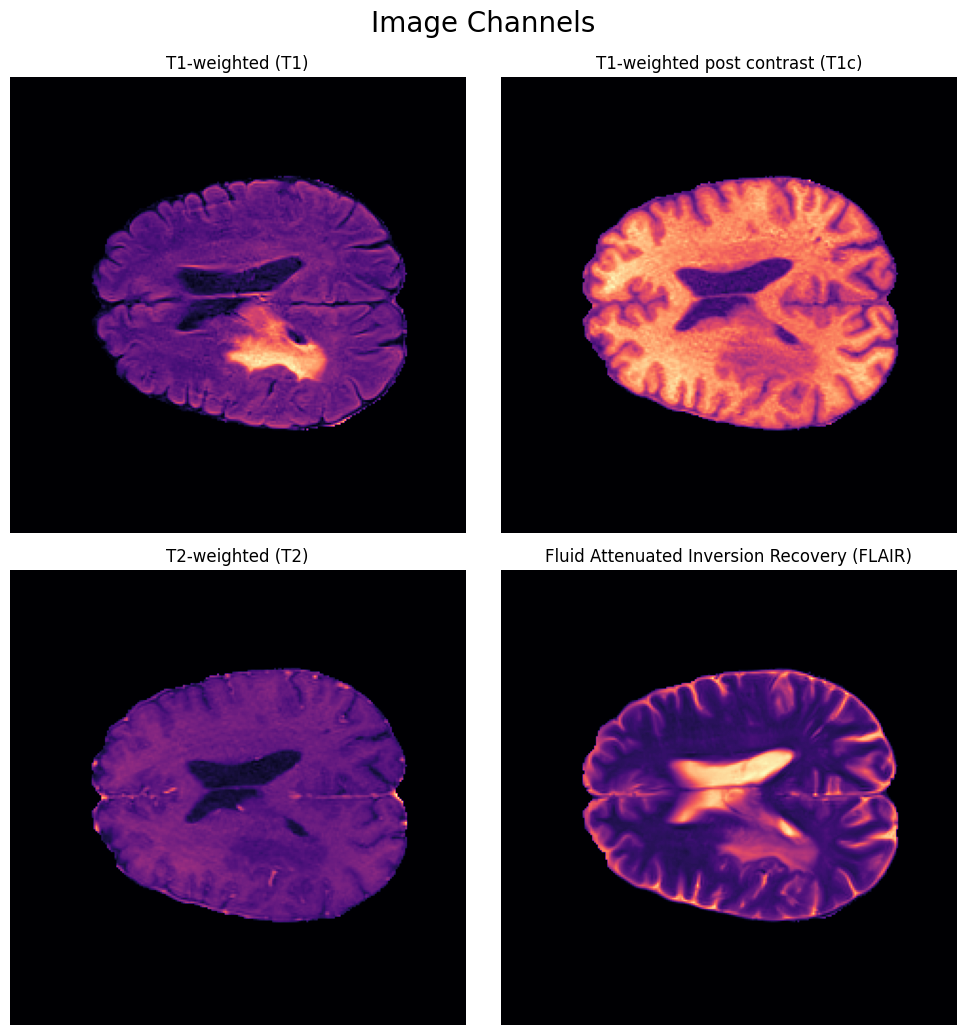

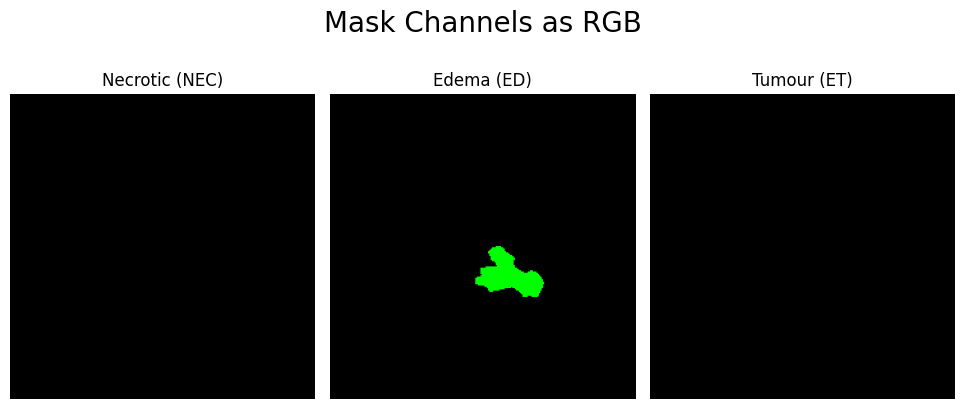

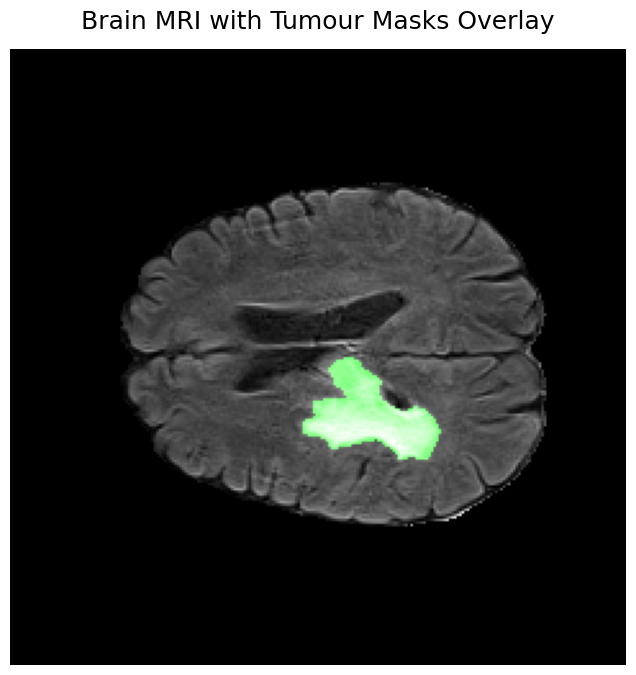

In [15]:
sanmple_data = {}
sample_file_path = str(h5_files[300])
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        sanmple_data[key] = file[key][()]

image = sanmple_data['image'].transpose(2, 0, 1)
mask = sanmple_data['mask'].transpose(2, 0, 1)

display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [16]:
meta_dict = {'image_shape':[],'mask_shape':[],'flair_mima':[],'t1_mima':[], 't1ce_mima':[],'t2_mima':[]}

for path in tqdm(h5_files): 
    str_path = str(path)
    with h5py.File(str_path, 'r') as file:
        if "image" in file.keys():
            image = file['image']
            flare = image[:, :, 0]
            t1 = image[:, :, 1]
            t1ce = image[:, :, 2]
            t2 = image[:, :, 3]
            meta_dict['flair_mima'].append([np.min(flare), np.max(flare)])
            meta_dict['t1_mima'].append([np.min(t1), np.max(t1)])
            meta_dict['t1ce_mima'].append([np.min(t1ce), np.max(t1ce)])
            meta_dict['t2_mima'].append([np.min(t2), np.max(t2)])
            meta_dict['image_shape'].append(image.shape)
        else:
            print(f"{str_path} does not have an image dataset")

        if "mask" in file.keys():
            mask = file["mask"]
            meta_dict['mask_shape'].append(mask.shape)
        else:
            print(f"{str_path} does not have a mask dataset")


  0%|          | 0/57195 [00:00<?, ?it/s]

In [17]:
meta_df = pd.DataFrame(meta_dict)
print(meta_df['image_shape'].unique())
print(meta_df['mask_shape'].unique())

[(240, 240, 4)]
[(240, 240, 3)]


In [18]:
meta_df['flair_min'] = meta_df['flair_mima'].apply(lambda x : x[0])
meta_df['flair_max'] = meta_df['flair_mima'].apply(lambda x : x[1])

meta_df['t1_min'] = meta_df['t1_mima'].apply(lambda x : x[0])
meta_df['t1_max'] = meta_df['t1_mima'].apply(lambda x : x[1])

meta_df['t1ce_min'] = meta_df['t1ce_mima'].apply(lambda x : x[0])
meta_df['t1ce_max'] = meta_df['t1ce_mima'].apply(lambda x : x[1])

meta_df['t2_min'] = meta_df['t2_mima'].apply(lambda x : x[0])
meta_df['t2_max'] = meta_df['t2_mima'].apply(lambda x : x[1])

<Axes: xlabel='value', ylabel='Count'>

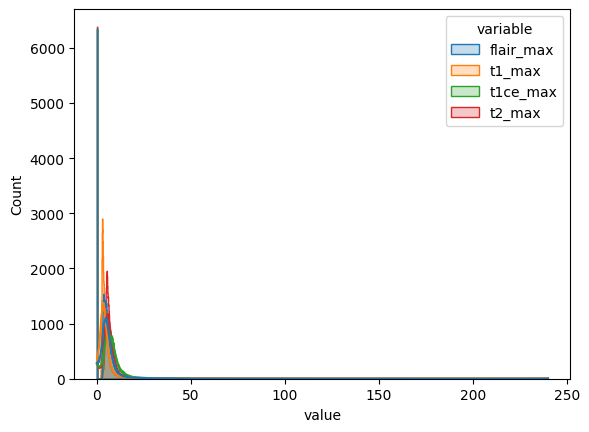

In [19]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_max','t1_max','t1ce_max','t2_max'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step")

<Axes: xlabel='value', ylabel='Density'>

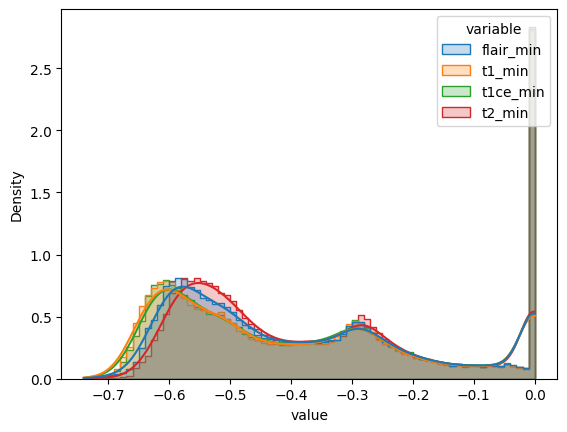

In [20]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_min','t1_min','t1ce_min','t2_min'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step", stat="density")